In [2]:
# using DifferentialEquations
# using ADCME
using Plots

In [3]:
function compute_cpHS(a, R, T)
    m = size(a)[1]
    cpHS = zeros(m, 3)
    for i = 1:m
        if (T > a[i,1])
            cpHS[i,1] = (a[i,2] + a[i,3] * T + a[i,4] * T^2 + a[i,5] * T^3 + a[i,6] * T^4) * R
            cpHS[i,2] = (a[i,2] + a[i,3] * T / 2 + a[i,4] * T^2 /3 + a[i,5] * T^3 /4 + a[i,6] * T^4 /5 + a[i,7]/T) * R * T
            cpHS[i,3] = (a[i,2] * log(T) + a[i,3] * T + a[i,4] * T^2 /2 + a[i,5] * T^3 /3 + a[i,6] * T^4 / 4 + a[i,8]) * R
        else
            cpHS[i,1] = (a[i,9] + a[i,10] * T + a[i,11] * T^2 + a[i,12] * T^3 + a[i,13] * T^4) * R
            cpHS[i,2] = (a[i,9] + a[i,10] * T / 2 + a[i,11] * T^2 /3 + a[i,12] * T^3 /4 + a[i,13] * T^4 /5 + a[i,14]/T) * R * T
            cpHS[i,3] = (a[i,9] * log(T) + a[i,10] * T + a[i,11] * T^2 /2 + a[i,12] * T^3 /3 + a[i,13] * T^4 / 4 + a[i,15]) * R        
        end
    end
    return cpHS
end

function compute_falloff(T, pr, a)
    fcent = (1 - a[1]) * exp(-T/a[2]) + a[1] * exp(-T/a[3]) + exp(-a[4]/T)
    c = -0.4 - 0.67 * log(10, fcent)
    n = 0.75 - 1.27 * log(10, fcent)
    f1 = (log(10, pr) + c) / (n - 0.14 *(log(10, pr) + c))
    return  10 ^ (log(10, fcent) / (1 + f1 ^ 2))
end

compute_falloff (generic function with 1 method)

In [4]:
using PyCall
#### Read data
py"""
import numpy as np
"""

In [19]:
V = 1  # Volume
m = 0.3778511846534872  # Total mass
tbd = py"np.load"(".npy files/tbd.npy") .+ 1
falofr = py"np.load"(".npy files/falofr.npy") .+ 1
elmr = py"np.load"(".npy files/elmr.npy") .+ 1
NASA_coeffs = py"np.load"(".npy files/NASA_coeffs.npy")
W = py"np.load"(".npy files/molecular_weights.npy")  # Molar weight
ν1 = py"np.load"(".npy files/reactants_stoich_coeffs.npy")  # Forward molar stoichiometric coefficients
ν2 = py"np.load"(".npy files/product_stoich_coeffs.npy")  # Backward model stoichiometric coefficients
reversible = py"np.load"(".npy files/reversible.npy")
N = size(ν1)[1]  # Number of Species
M = size(ν1)[2]  # Number of Reactions
ν1_order = zeros(N,M)
ν = ν2 - ν1  
pa = 100000  # 1 bar
R = 8314.4621  # Gas constant in kmol
### Constants: Combustion Chamber Level
min_dot = 0.0094  # Specified mass inflow [kg/s]
mout_dot = 0.00577  # Rate at which mass leaves the chamber [kg/s]
Yin = ones(N)  # Mass fraction of species entering the chamber
Yout = ones(N)  # Mass fraction of species leaving the chamber
Qdot = 0  # Heating source
m_dot = min_dot - mout_dot
hin = 1  # Enthalpy of input
### Unknowns
T = 350.0  # Temperature
Y = py"np.load"(".npy files/ini_mass_fraction.npy")  # Mass fractions
### Quantities that depend on the Unknowns
tbd = py"np.load"(".npy files/tbd.npy") .+ 1
falofr = py"np.load"(".npy files/falofr.npy") .+ 1
elmr = py"np.load"(".npy files/elmr.npy") .+ 1

order = py"np.load"(".npy files/reaction_orders.npy")
Af = py"np.load"(".npy files/pre_exponential_factor.npy")  # preexponential constant Afj
β = py"np.load"(".npy files/temperature_exponent.npy")  # Temperature exponent
E = py"np.load"(".npy files/activation_energy.npy")  # Activation energy for the reactions in kJ

order_t = py"np.load"(".npy files/reaction_orders_t.npy")
efficiency_t = py"np.load"(".npy files/efficiency_t.npy")
Af_t = py"np.load"(".npy files/pre_exponential_factor_t.npy")  # preexponential constant Afj
β_t = py"np.load"(".npy files/temperature_exponent_t.npy")  # Temperature exponent
E_t = py"np.load"(".npy files/activation_energy_t.npy")  # Activation energy for the reactions in kJ

order_f = py"np.load"(".npy files/reaction_orders_f.npy")
troefall = py"np.load"(".npy files/troefall.npy") .+ 1
troefall_coeff = py"np.load"(".npy files/troefall_coeff.npy")
efficiency_f = py"np.load"(".npy files/efficiency_f.npy")
Af_hi = py"np.load"(".npy files/pre_exponential_factor_hi.npy")  # preexponential constant Afj
β_hi = py"np.load"(".npy files/temperature_exponent_hi.npy")  # Temperature exponent
E_hi = py"np.load"(".npy files/activation_energy_hi.npy") 

Af_lo = py"np.load"(".npy files/pre_exponential_factor_lo.npy")  # preexponential constant Afj
β_lo = py"np.load"(".npy files/temperature_exponent_lo.npy")  # Temperature exponent
E_lo = py"np.load"(".npy files/activation_energy_lo.npy") 

ν1_order[:,elmr] = order
ν1_order[:,tbd] = order_t
ν1_order[:,falofr] = order_f

6×0 Array{Float64,2}

In [20]:
ρ = m / V # density
X = ρ * Y ./ W # Concentration
Q = ones(M) # Individual progress rates
cpHS = compute_cpHS(NASA_coeffs, R, T)
cp = cpHS[:,1]  # Values for the different species, not for different time values!
# print(size(cp))
h = cpHS[:,2]
s = cpHS[:,3]
cvk = cp .- R
ΔS = ν' * s  # Entropy change for reaction j
ΔH = ν' * h # Entahlpy change for reaction j
####
M_t = efficiency_t' * X
Kf_t = Af_t .* (T .^ β_t) .* exp.(-E_t ./ (R * T)) .* M_t
Kr_t = Kf_t ./ (((pa/(R * T)) .^ sum(ν[:,tbd], dims=1)' .* exp.(ΔS[tbd] ./ R - ΔH[tbd] ./ (R * T))))
Q[tbd] = Kf_t .* prod(X .^ order_t, dims=1)' .- Kr_t .* prod(X .^ ν2[:,tbd], dims=1)' .* reversible[tbd]
####
M_f = efficiency_f' * X
Kf_lo = Af_lo .* (T .^ β_lo) .* exp.(-E_lo ./ (R * T)) .* M_f
Kf_hi = Af_hi .* (T .^ β_hi) .* exp.(-E_hi ./ (R * T)) 
Pr = Kf_lo ./ Kf_hi
Fac = ones(size(falofr)[1])
Fac[troefall] = [compute_falloff(T, Pr[s], troefall_coeff[:,i]) for (i,s) in enumerate(troefall)]
Kf_f = Kf_lo ./ (1 .+ (Kf_lo ./ Kf_hi)) .* Fac
Kr_f = Kf_f ./ (((pa/(R * T)) .^ sum(ν[:,falofr], dims=1)' .* exp.(ΔS[falofr] ./ R - ΔH[falofr] ./ (R * T))))
Q[falofr] = Kf_f .* prod(X .^ order_f, dims=1)' .- Kr_f .* prod(X .^ ν2[:,falofr], dims=1)' .* reversible[falofr]
####
Kf = Af .* (T .^ β) .* exp.(-E ./ (R * T))
Kr = Kf ./ (((pa/(R * T)) .^ sum(ν[:,elmr], dims=1)' .* exp.(ΔS[elmr] ./ R - ΔH[elmr] ./ (R * T))))
Q[elmr] = Kf .* prod(X .^ order, dims=1)' .- Kr .* prod(X .^ ν2[:,elmr], dims=1)' .* reversible[elmr]
##### Computing ω_dot 
cv = sum(cvk ./ W .* Y) # Mass heat capacities
total_cp = cp'*Y
# print(total_cp)
u = h ./ W - R ./ W .* T   # Internal energy for species
p = sum(X) * R * T # pressure
ω_dot = W .* sum(ν .* Q', dims=2)
###### Species Conservation
mgen_dot = V .* ω_dot
Y_dot = (1 / m) .* (min_dot .* (Yin .- Y) - mout_dot .* Y .+ mgen_dot) 
###### Energy Conservation
T_dot = 1 / (m * cv) * (-Qdot + min_dot * (hin - sum(u .* Yin)) - p * V / m * mout_dot - sum(mgen_dot .* u))

908.174425569174

In [21]:
function f(TY)
    T = TY[1]
    Y = TY[2:end]
    ρ = m / V # density
    X = ρ * Y ./ W # Concentration
    Q = ones(M) # Individual progress rates
    cpHS = compute_cpHS(NASA_coeffs, R, T)
    cp = cpHS[:,1]
    total_cp = cp'*Y
    h = cpHS[:,2]
    s = cpHS[:,3]
    cvk = cp .- R
    ΔS = ν' * s  # Entropy change for reaction j
    ΔH = ν' * h # Entahlpy change for reaction j
    ####
    M_t = efficiency_t' * X
    Kf_t = Af_t .* (T .^ β_t) .* exp.(-E_t ./ (R * T)) .* M_t
    Kr_t = Kf_t ./ (((pa/(R * T)) .^ sum(ν[:,tbd], dims=1)' .* exp.(ΔS[tbd] ./ R - ΔH[tbd] ./ (R * T))))
    Q[tbd] = Kf_t .* prod(X .^ order_t, dims=1)' .- Kr_t .* prod(X .^ ν2[:,tbd], dims=1)' .* reversible[tbd]
    ####
    M_f = efficiency_f' * X
    Kf_lo = Af_lo .* (T .^ β_lo) .* exp.(-E_lo ./ (R * T)) .* M_f
    Kf_hi = Af_hi .* (T .^ β_hi) .* exp.(-E_hi ./ (R * T)) 
    Pr = Kf_lo ./ Kf_hi
    Fac = ones(size(falofr)[1])
    Fac[troefall] = [compute_falloff(T, Pr[s], troefall_coeff[:,i]) for (i,s) in enumerate(troefall)]
    Kf_f = Kf_lo ./ (1 .+ (Kf_lo ./ Kf_hi)) .* Fac
    Kr_f = Kf_f ./ (((pa/(R * T)) .^ sum(ν[:,falofr], dims=1)' .* exp.(ΔS[falofr] ./ R - ΔH[falofr] ./ (R * T))))
    Q[falofr] = Kf_f .* prod(X .^ order_f, dims=1)' .- Kr_f .* prod(X .^ ν2[:,falofr], dims=1)' .* reversible[falofr]
    ####
    Kf = Af .* (T .^ β) .* exp.(-E ./ (R * T))
    Kr = Kf ./ (((pa/(R * T)) .^ sum(ν[:,elmr], dims=1)' .* exp.(ΔS[elmr] ./ R - ΔH[elmr] ./ (R * T))))
    Q[elmr] = Kf .* prod(X .^ order, dims=1)' .- Kr .* prod(X .^ ν2[:,elmr], dims=1)' .* reversible[elmr]
    ##### Computing ω_dot 
    cv = sum(cvk ./ W .* Y) # Mass heat capacities, dot product with mass fractions Y to compute total cv
    u = h ./ W - R ./ W .* T   # Internal energy for species
    p = sum(X) * R * T # pressure
    ω_dot = W .* sum(ν .* Q', dims=2)
    ###### Species Conservation
    mgen_dot = V .* ω_dot
    
    # Compute mout_dot using nozzle equations
    gamma = cp./cv  # Need to use values generated over different time values, not the current cp/cv values for different species
    # print(size(cp))
    A_3 = 1 # [m^2], arbitrary cross-sectional area for nozzle
    # Need to have p2p4 ratio instead for m3_dot?
    p2p3_ratio = (1 .+ (gamma.-1)./2).^(gamma./(gamma.-1)) # Ratio of p2/p3, which is fixed for choked nozzle

    p_3 = 101325 # Test value, approximately atmospheric pressure at nozzle exit
    p_2 = p2p3_ratio.*p_3
    
    ρ_2 = ρ # rho, test value, uses density values defined in an above cell
    sqrt_left = sqrt.(real((2 .*gamma)./(gamma .- 1)))  # Arguments become complex depending on timescale, such as dt = 1e-7?
    sqrt_right = sqrt.(real(p_2.*ρ_2 .* ((p2p3_ratio).^(-2 ./gamma) .- (p2p3_ratio).^(-(gamma .+ 1)./gamma))))
    mout_dot = A_3.*sqrt_left.*sqrt_right
    mout_dot = mout_dot[1]
    # print(T)
    
    # min_dot can be set as a constant or Gaussian
    min_dot = 1e1  # Possibly needs tweeking; used to be 1e10, changed to match mfc constructor
    Y_dot = (1 / m) .* (min_dot .* (Yin .- Y) - mout_dot .* Y .+ mgen_dot) 
    ###### Energy Conservation
    T_dot = 1 / (m * cv) * (-Qdot + min_dot * (hin - sum(u .* Yin)) - p * V / m * mout_dot - sum(mgen_dot .* u))
    
    # Y_dot = (1 / m) .* (min_dot .* (Yin .- Y) .- mout_dot .* Y .+ mgen_dot) 
    ###### Energy Conservation
    # T_dot = 1 / (m * cv) * (-Qdot + min_dot * (hin - sum(u .* Yin)) .- p * V / m * mout_dot .- sum(mgen_dot .* u))
    return [T_dot; Y_dot], total_cp, cv
end

f (generic function with 1 method)

In [52]:
## RK4
dt = 1e-11  # Timescale used to be 1e-14
n_t = 200
T = 350.0 # Temperature
Y = py"np.load"(".npy files/ini_mass_fraction.npy") # Mass fractions
TY = [T;Y]
Tt = zeros(n_t)
Pt = zeros(n_t)
Yt = zeros(N,n_t)
cp = zeros(n_t)
print(size(cp))
cv = zeros(n_t)
Y0 = copy(Y)
for i = 1:n_t
    #println(i)
    k1, total_cp, total_cv = f(TY)
    k2, total_cp, total_cv = f(TY + 0.5 * dt * k1)
    k3, total_cp, total_cv = f(TY + 0.5 * dt * k2)
    k4, total_cp, total_cv = f(TY + dt * k3)
    cp[i] = total_cp
    cv[i] = total_cv
    TY += 1/6 * dt * (k1 + 2 * k2 + 2 * k3 + k4)
    Tt[i] = TY[1]
    Y = TY[2:end]
    Yt[:,i] = Y
    X = ρ * Y ./ W
    p = sum(X) * R * TY[1]
    Pt[i] = p
end

(200,)

In [53]:
# Nozzle Implementation, also incorporated into function f above
# Use function f above to recalculate gas parameters at each time step

gamma = cp./cv  # Need to use values generated over different time values, not the current cp/cv values for different species
print(size(cp))
A_3 = 0.001  # [m^2], arbitrary cross-sectional area for nozzle -- may be too big
# Need to have p2p4 ratio instead for m3_dot?
p2p3_ratio = (1 .+ (gamma.-1)./2).^(gamma./(gamma.-1)) # Ratio of p2/p3, which is fixed for choked nozzle


p_3 = 101325  # Test value, approximately atmospheric pressure at nozzle exit
p_2 = p2p3_ratio.*p_3

ρ_2 = ρ  # rho, test value, uses density values defined in an above cell
# print(size(ρ_2))

(200,)

0.3778511846534872

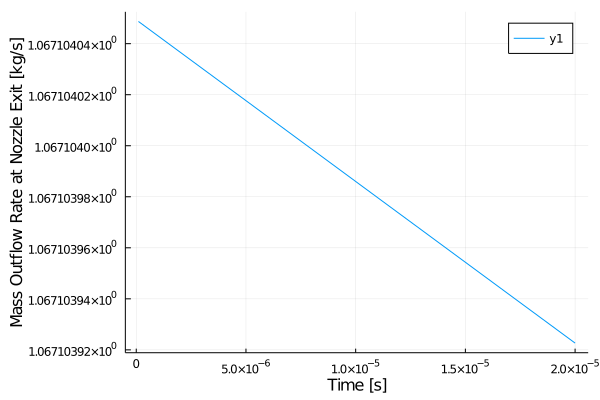

In [54]:
sqrt_left = sqrt.((2 .*gamma)./(gamma .- 1))
sqrt_right = sqrt.(p_2.*ρ_2 .* ((p2p3_ratio).^(-2 ./gamma) .- (p2p3_ratio).^(-(gamma .+ 1)./gamma)))
m3_dot = A_3.*sqrt_left.*sqrt_right

X = [i * 1e-7 for i = 1:n_t]  # Timescale used to be 1e-14
time = X[1:200]
plot(time, m3_dot)
# plot(time, gamma)
xlabel!("Time [s]")
ylabel!("Mass Outflow Rate at Nozzle Exit [kg/s]")

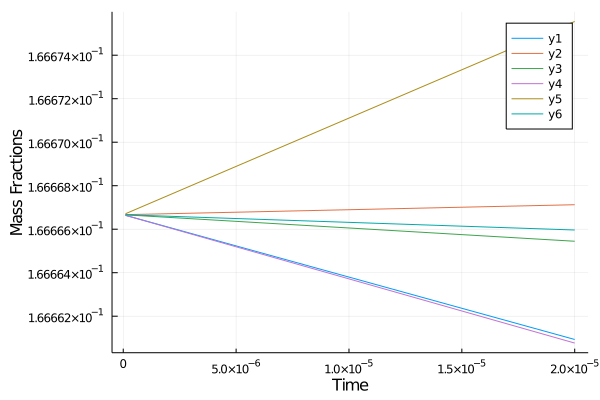

In [38]:
X = [i * 1e-7 for i = 1:n_t]  # Timescale used to be 1e-14
Yt_cant = py"np.load"(".npy files/mass_fraction.npy")
plot(X, Yt')
xlabel!("Time")
ylabel!("Mass Fractions")
#savefig("Mass_fraction.pdf")

In [55]:
print(size(X))
print(size(Pt))
print(size(Pt_cant))

(200,)(200,)(501,)

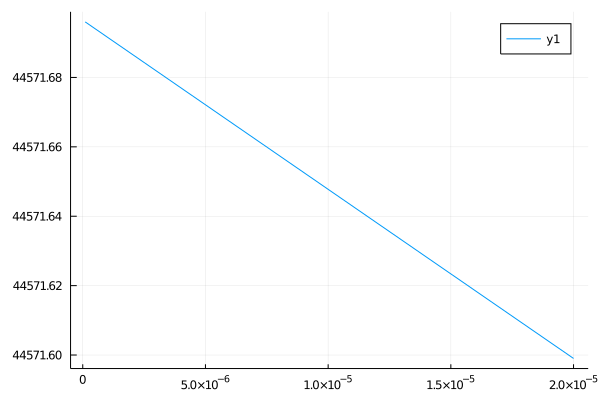

In [56]:
plot(X, Pt)

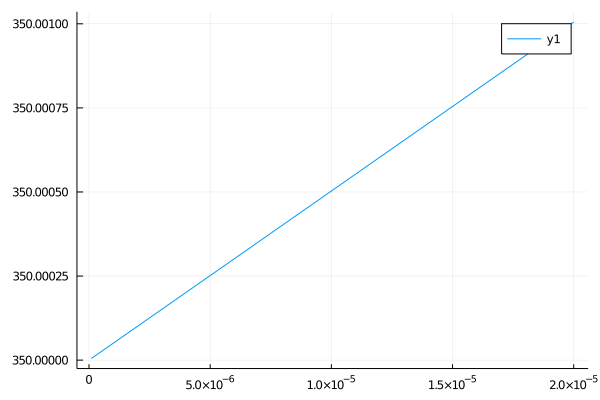

In [45]:
plot(X, Tt)

In [12]:
Pt_cant = py"np.load"(".npy files/pressure.npy")
plot(X, [Pt Pt_cant], label = ["Julia" "Cantera"])
xlabel!("Time")
ylabel!("Pressure")
#savefig("Pressure.pdf")

LoadError: DimensionMismatch("vectors must have same lengths")

In [14]:
plot(X, Tt)
Tt_cant = py"np.load"(".npy files/temperature.npy")
plot(X, [Tt Tt_cant], label = ["Julia" "Cantera"])
xlabel!("Time")
ylabel!("Temperature")
#savefig("Temperature.pdf")

LoadError: DimensionMismatch("vectors must have same lengths")

In [ ]:
# ty = ADCME.Variable(TY)
# uu = ADCME.Variable(TY)
# xx = ADCME.Variable(1.0)